<a href="https://colab.research.google.com/github/dvirchakim/dvirchakim/blob/main/image_process_proj_final_Q1_205654445.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Image Processing: Project Overview
## Authored by Dvir Chakim, ID: 205654445

This project utilizes the MedMNIST dataset for benchmarking deep learning models in medical image processing, following the official "Getting Started" guide provided by the MedMNIST repository.

**Key Resources:**
- **MedMNIST Dataset:** [Visit Here](https://medmnist.com/)
- **Getting Started Guide:** [Explore Here](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb)

### Project's Neural Network Model
The core of this project is the dvirCNN neural network, designed for image classification with PyTorch. It features customizable options for the number of output classes, input image size, and input channels, catering primarily to 3-channel (RGB) 28x28 pixel images. The architecture includes three convolutional layers, each followed by batch normalization and max pooling to enhance feature extraction and reduce dimensionality. The convolutional stack is succeeded by two fully connected layers, transitioning from spatial feature maps to class score outputs. This model emphasizes efficient feature processing and adaptability to various image classification tasks within the medical imaging domain.

## enviorment setting
Setting up the necessary Python environment and libraries for the project.

In [78]:
!pip install medmnist
!pip install scikit-learn
!pip install seaborn


In [2]:
# Plotting function
def plot_training_history(history):
    epochs = range(1, len(history['loss']) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], 'bo-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['accuracy'], 'bo-', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_training_history1(history):
    epochs = range(1, len(history['train_losses1']) + 1)
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, history['train_losses1'], label='Train Loss')
    plt.plot(epochs, history['train_accuracies1'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss / Accuracy')
    plt.legend()
    plt.show()


In [18]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
print("import done")

import done


## Model pre process

In [4]:
data_flag = 'pathmnist'
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [5]:
# DIRECT DATA preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [6]:
# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)


100%|██████████| 205615438/205615438 [00:16<00:00, 12491775.66it/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [7]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

print the layout


In [8]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K


## visualize pre-processed data

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


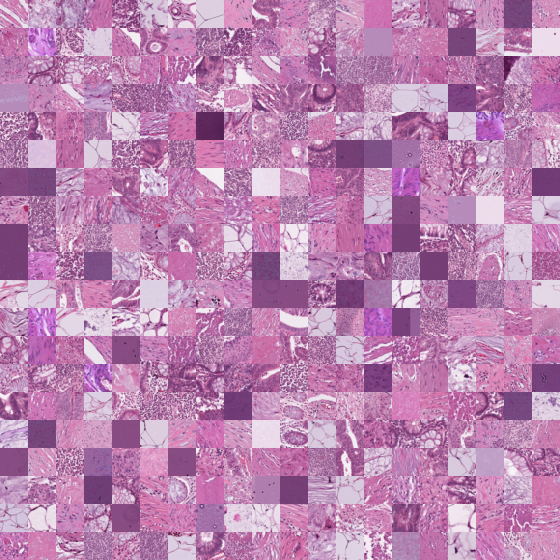

In [9]:
# montage
train_dataset.montage(length=1)
train_dataset.montage(length=20)

## THE MODEL

## Defining the Convolutional Neural Network

In [12]:
class dvirCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(dvirCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()



# initialize model
model = dvirCNN(num_classes=n_classes, in_channels=3)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

TIME TO TRAIN

## Training and Evaluation

The following code defines the training and evaluation loop. It iterates over a specified number of epochs, training the model and evaluating it on both the training and test datasets at the end of each epoch.


In [13]:
train_losses = []
train_accuracies = []

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    epoch_loss = train_loss / len(train_loader)
    epoch_accuracy = 100 * train_correct / train_total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')


100%|██████████| 704/704 [02:40<00:00,  4.39it/s]


Epoch 1, Loss: 1.1020, Accuracy: 60.61%


100%|██████████| 704/704 [02:42<00:00,  4.33it/s]


Epoch 2, Loss: 0.5592, Accuracy: 79.63%


100%|██████████| 704/704 [02:56<00:00,  3.98it/s]


Epoch 3, Loss: 0.4375, Accuracy: 84.27%


100%|██████████| 704/704 [02:48<00:00,  4.17it/s]


Epoch 4, Loss: 0.3642, Accuracy: 87.12%


100%|██████████| 704/704 [02:43<00:00,  4.30it/s]


Epoch 5, Loss: 0.3163, Accuracy: 88.80%


100%|██████████| 704/704 [02:40<00:00,  4.40it/s]


Epoch 6, Loss: 0.2837, Accuracy: 89.97%


100%|██████████| 704/704 [02:37<00:00,  4.47it/s]


Epoch 7, Loss: 0.2543, Accuracy: 91.08%


100%|██████████| 704/704 [02:41<00:00,  4.36it/s]


Epoch 8, Loss: 0.2323, Accuracy: 91.86%


100%|██████████| 704/704 [02:42<00:00,  4.33it/s]


Epoch 9, Loss: 0.2092, Accuracy: 92.70%


100%|██████████| 704/704 [02:35<00:00,  4.51it/s]

Epoch 10, Loss: 0.1955, Accuracy: 93.24%


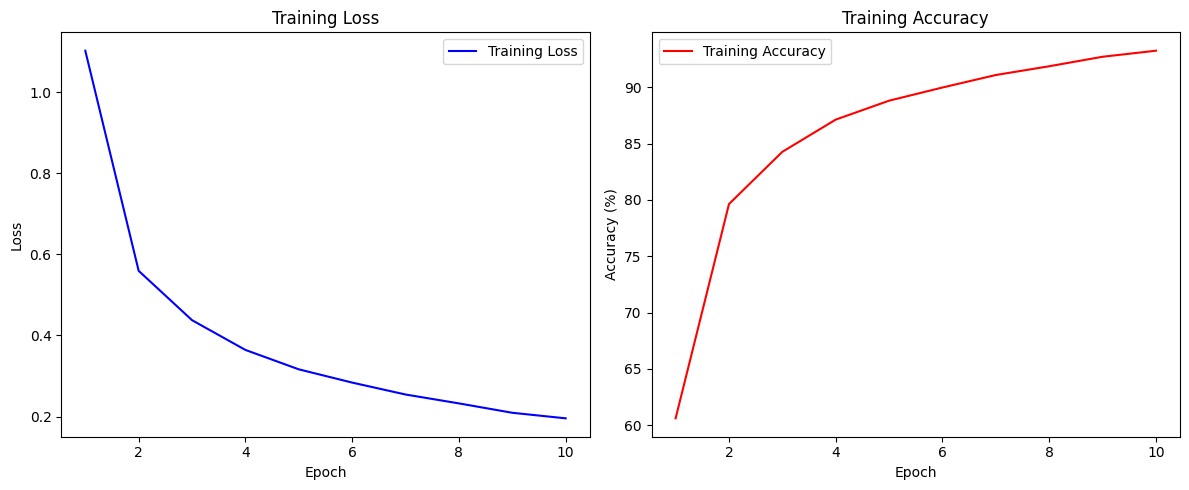

In [15]:
# Plotting
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Training Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS+1), train_accuracies, label='Training Accuracy', color='red')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Drums...🥁🥁🥁

In [83]:
def calculate_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')  # Adjust 'average' as needed
    precision = precision_score(y_true, y_pred, average='macro')  # Adjust 'average' as needed

    # Plotting Confusion Matrix using Seaborn
    plt.figure(figsize=(10, 7))  # Set figure size
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print('Recall: %.3f' % recall)
    print('Precision: %.3f' % precision)


==> Evaluating Train Set...


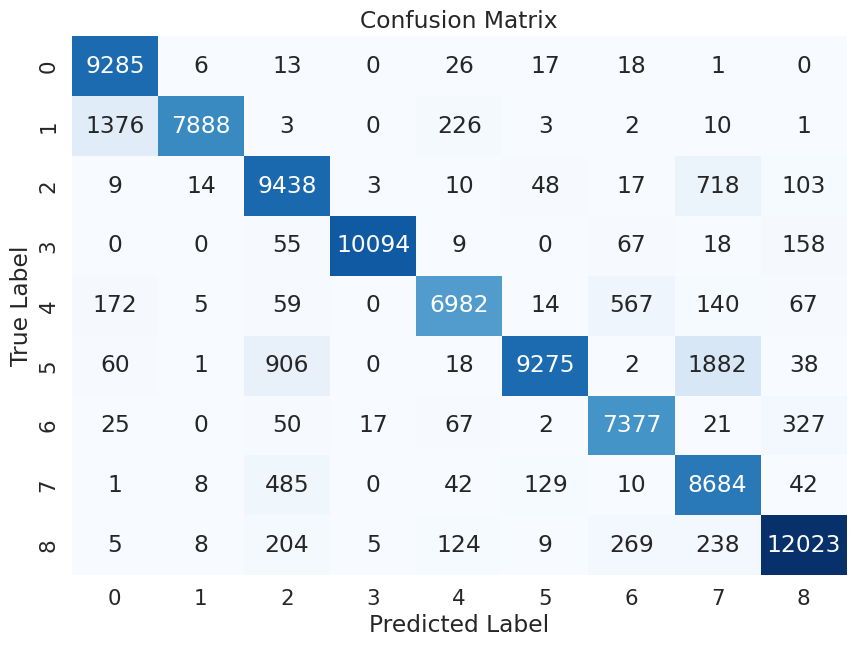

Recall: 0.903
Precision: 0.907
==> Evaluating Test Set...


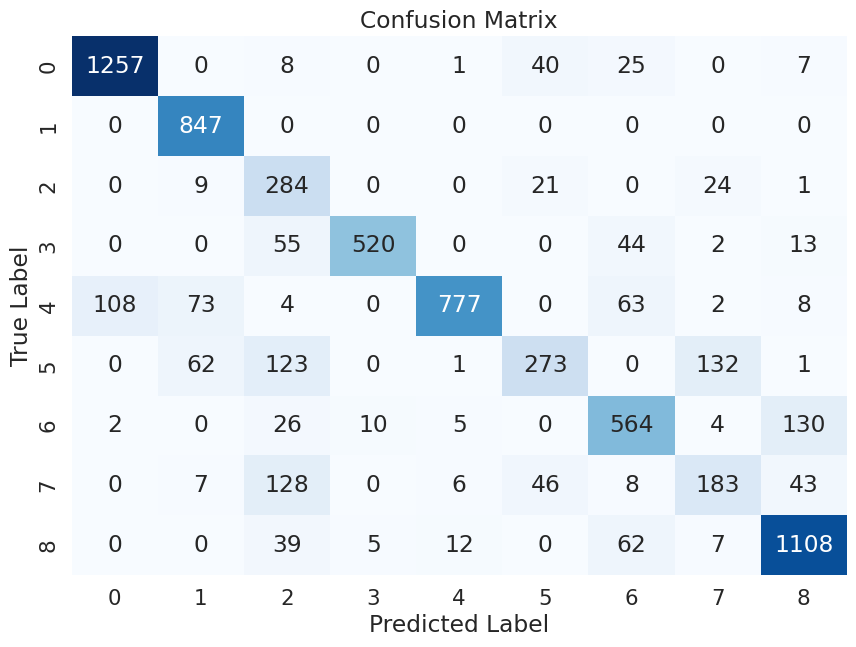

Recall: 0.767
Precision: 0.772


In [84]:
def test(split):
    model.eval()
    y_true = torch.tensor([], dtype=torch.float32)
    y_pred = torch.tensor([], dtype=torch.long)  # This will store predicted classes

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
                predictions = (outputs > 0.5).long()  # Assuming threshold of 0.5 for binary classification
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                _, predictions = torch.max(outputs, 1)  # Get the index of the max log-probability as prediction

            y_true = torch.cat((y_true, targets), 0)
            y_pred = torch.cat((y_pred, predictions), 0)

    # Convert tensors to NumPy arrays for sklearn compatibility
    y_true_np = y_true.numpy()
    y_pred_np = y_pred.numpy()

    # Calculate and print evaluation metrics
    calculate_metrics(y_true_np, y_pred_np)

print('==> Evaluating Train Set...')
test('train')
print('==> Evaluating Test Set...')
test('test')

train and eval with implemented early stopping

100%|██████████| 704/704 [02:42<00:00,  4.34it/s]


Epoch 1, Loss: 0.1095, Accuracy: 96.17%
Validation Loss: 0.6833


100%|██████████| 704/704 [02:36<00:00,  4.49it/s]


Epoch 2, Loss: 0.1020, Accuracy: 96.47%
Validation Loss: 1.2245


100%|██████████| 704/704 [02:49<00:00,  4.16it/s]


Epoch 3, Loss: 0.0977, Accuracy: 96.63%
Validation Loss: 0.8981


100%|██████████| 704/704 [02:41<00:00,  4.37it/s]


Epoch 4, Loss: 0.0903, Accuracy: 96.77%
Validation Loss: 1.0109


100%|██████████| 704/704 [02:51<00:00,  4.12it/s]


Epoch 5, Loss: 0.0863, Accuracy: 97.05%
Validation Loss: 1.1234


100%|██████████| 704/704 [02:42<00:00,  4.33it/s]


Epoch 6, Loss: 0.0844, Accuracy: 97.05%
Validation Loss: 0.8617
No improvement in 5 epochs, stopping early.
Epoch 6/10, Train Loss: 0.0844, Train Acc: 97.05%, Val Loss: 0.8617


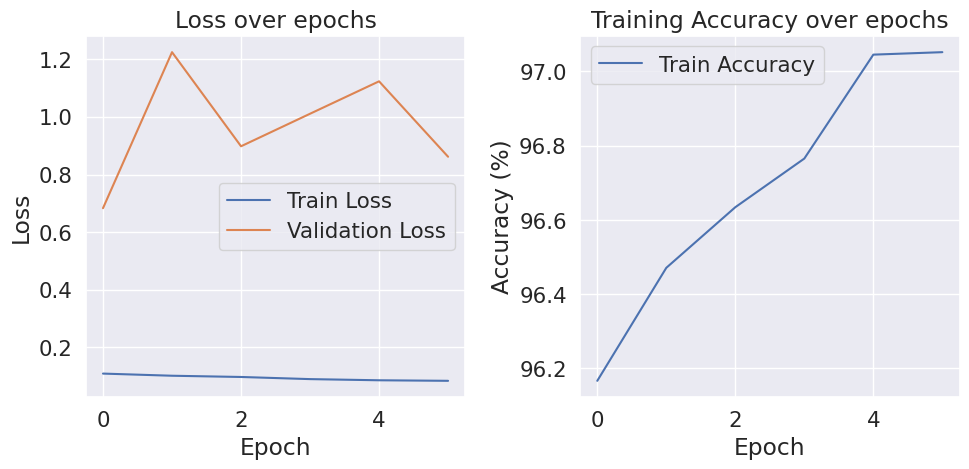

In [90]:
best_loss = float('inf')  # Initialize best_loss to a very high value
epochs_no_improve = 0
patience = 5  # How many epochs to wait after last time validation loss improved.
early_stop = False

train_losses = []
train_accuracies = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    if early_stop:
        print("Early stopping triggered")
        break  # Break the loop if early stopping was triggered

    # Training Phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)

        # Adjust targets based on your specific task and loss function
        targets = targets.to(torch.float32) if task == 'multi-label, binary-class' else targets.squeeze().long()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    epoch_loss = train_loss / len(train_loader)
    epoch_accuracy = 100 * train_correct / train_total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            targets = targets.to(torch.float32) if task == 'multi-label, binary-class' else targets.squeeze().long()
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    print(f'Validation Loss: {val_loss:.4f}')

    # Early Stopping Check
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"No improvement in {patience} epochs, stopping early.")
            break

print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}')

# Plotting
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Training Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


as we can see the early stopping noticed ne change and stopped the process earlier than it should have .